## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

## Importing the modified dataset

In [2]:
train_values = pd.read_csv('./dataset_modified/train_values.csv')
train_labels = pd.read_csv('./dataset_modified/train_labels.csv')
test_values = pd.read_csv('./dataset_modified/test_values.csv')

## Implementing Models
1) XGBoost

In [3]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels['damage_grade'], test_size=0.3, random_state=10) # 70% training and 30% test
X_train = X_train.drop(columns = 'building_id')
X_test  = X_test.drop (columns = 'building_id')

In [4]:
def print_confusion_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    df_cm = pd.DataFrame(cm, columns=np.unique(y_train), index = np.unique(y_train))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    ax.get_ylim()
    ax.set_ylim(3.0, 0)

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

y_train = sc.fit_transform([y_train])
y_test = sc.fit_transform([y_test])# # THE FOLLOWING CODE IS COMMENTED OUT AS IT TAKES A VERY LONG TO EXECUTE ....

# # The following code does a Random Search on the hyperparameters of the XGBoost Model to optimise the model


# from sklearn.model_selection import RandomizedSearchCV

# params={
#  "learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
#  "max_depth"        : [ 5, 6, 8, 9, 10, 12],
#  "min_child_weight" : [ 0, 1, 2, 3.5, 5 ],
#  "gamma"            : [ 0.0, 0.1, 0.25, 0.3, 0.4],
#  "colsample_bytree" : [ 0.7, 0.75, 0.8, 0.85],
#  "subsample"        : [ 0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
#  "n_estimators"     : [ 50, 80, 100]
    
# }

# classifier = xgb.XGBClassifier(objective = 'multi:softmax')

# random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=3)
# random_search.fit(X_train,y_train)

# # The above code returns the following output of parameters which can further be used for the XGBoost Model

# # {
# #     'subsample': 0.7, 
# #     'min_child_weight': 5, 
# #     'max_depth': 12, 
# #     'learning_rate': 0.2, # 'eta' in the model below
# #     'gamma': 0.4, 
# #     'colsample_bytree': 0.7
# # }


In [6]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test, label = y_test_xgb)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# XGBoost Model Accuracy
print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/home/aishwarya/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy of XGBoost:  0.743901971067
              precision    recall  f1-score   support

           1       0.68      0.51      0.59      7481
           2       0.74      0.85      0.79     44440
           3       0.76      0.63      0.69     26260

    accuracy                           0.74     78181
   macro avg       0.73      0.66      0.69     78181
weighted avg       0.74      0.74      0.74     78181



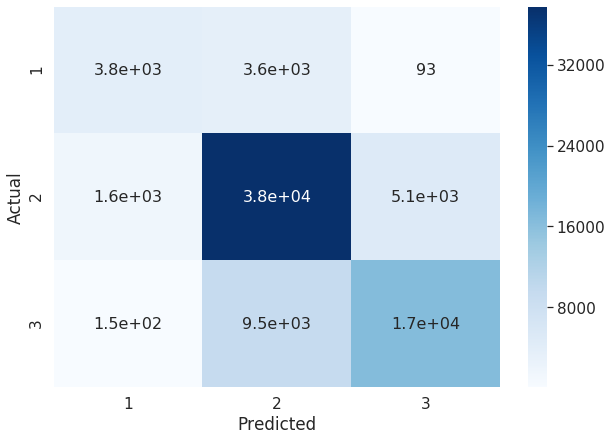

In [7]:
print_confusion_matrix(y_test, y_pred)

## Undersampling the majority class

In [8]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels['damage_grade'], test_size=0.3, random_state=10) # 70% training and 30% test
X_train = X_train.drop(columns = 'building_id')
X_test  = X_test.drop (columns = 'building_id')

X = pd.concat([X_train, y_train], axis=1)

damage1 = X[X.damage_grade == 1]
damage2 = X[X.damage_grade == 2]
damage3 = X[X.damage_grade == 3]

undersampled = resample(damage2,
                        replace = False,
                        n_samples = len(damage3),
                        random_state = 25)

X = pd.concat([damage1, undersampled, damage3])

X_train = X.drop(['damage_grade'], axis=1)
y_train = X.damage_grade

In [9]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test, label = y_test_xgb)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# XGBoost Model Accuracy
print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy of XGBoost:  0.725329683683
              precision    recall  f1-score   support

           1       0.61      0.63      0.62      7481
           2       0.79      0.73      0.75     44440
           3       0.67      0.75      0.71     26260

    accuracy                           0.73     78181
   macro avg       0.69      0.70      0.69     78181
weighted avg       0.73      0.73      0.73     78181



## Oversampling the minority classes

In [10]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels['damage_grade'], test_size=0.3, random_state=10) # 70% training and 30% test
X_train = X_train.drop(columns = 'building_id')
X_test  = X_test.drop (columns = 'building_id')

X = pd.concat([X_train, y_train], axis=1)

damage1 = X[X.damage_grade == 1]
damage2 = X[X.damage_grade == 2]
damage3 = X[X.damage_grade == 3]

oversampled1 = resample(damage1,
                        replace = True,
                        n_samples = len(damage2),
                        random_state = 25)

oversampled3 = resample(damage3,
                        replace = True,
                        n_samples = len(damage2),
                        random_state = 25)

X = pd.concat([oversampled1, damage2, oversampled3])

X_train = X.drop(['damage_grade'], axis=1)
y_train = X.damage_grade

In [11]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test, label = y_test_xgb)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# XGBoost Model Accuracy
print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy of XGBoost:  0.713383047032
              precision    recall  f1-score   support

           1       0.50      0.78      0.61      7481
           2       0.79      0.70      0.74     44440
           3       0.69      0.72      0.71     26260

    accuracy                           0.71     78181
   macro avg       0.66      0.73      0.69     78181
weighted avg       0.73      0.71      0.72     78181



## SMOTE

In [12]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels['damage_grade'], test_size=0.3, random_state=10) # 70% training and 30% test
X_train = X_train.drop(columns = 'building_id')
X_test  = X_test.drop (columns = 'building_id')

smt = SMOTE()
X_train1, y_train1 = smt.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train1, columns = X_train.columns)
y_train = pd.Series(y_train1)

In [13]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test, label = y_test_xgb)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# XGBoost Model Accuracy
print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/home/aishwarya/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy of XGBoost:  0.731354165334
              precision    recall  f1-score   support

           1       0.59      0.62      0.60      7481
           2       0.76      0.78      0.77     44440
           3       0.72      0.68      0.70     26260

    accuracy                           0.73     78181
   macro avg       0.69      0.69      0.69     78181
weighted avg       0.73      0.73      0.73     78181



In [14]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy of Random Forest: ",clf.score(X_test, y_test))

Accuracy of Random Forest:  0.70393062253


## ADASYN

In [15]:
from imblearn.over_sampling import ADASYN

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels['damage_grade'], test_size=0.3, random_state=10) # 70% training and 30% test
X_train = X_train.drop(columns = 'building_id')
X_test  = X_test.drop (columns = 'building_id')

asyn = ADASYN()
X_train1, y_train1 = asyn.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train1, columns = X_train.columns)
y_train = pd.Series(y_train1)

In [16]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test, label = y_test_xgb)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# XGBoost Model Accuracy
print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/home/aishwarya/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy of XGBoost:  0.727248308413
              precision    recall  f1-score   support

           1       0.58      0.63      0.60      7481
           2       0.76      0.77      0.77     44440
           3       0.71      0.68      0.70     26260

    accuracy                           0.73     78181
   macro avg       0.68      0.69      0.69     78181
weighted avg       0.73      0.73      0.73     78181



In [17]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=300)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy of Random Forest: ",clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Accuracy of Random Forest:  0.698187539172
              precision    recall  f1-score   support

           1       0.54      0.61      0.57      7481
           2       0.75      0.73      0.74     44440
           3       0.67      0.66      0.67     26260

    accuracy                           0.70     78181
   macro avg       0.65      0.67      0.66     78181
weighted avg       0.70      0.70      0.70     78181



For datadriven

In [18]:
# Split dataset into training set and test set
y_train= train_labels['damage_grade']

X_train = train_values.drop(columns = 'building_id')
X_test  = test_values.drop (columns = 'building_id')

In [19]:
# XGBoost Model

# xgboost classifier accepts classes only in the range [0, num_class)
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# transforming data into DMatrix for it to be usable by XGBoost
D_train = xgb.DMatrix(X_train, label = y_train_xgb)
D_test = xgb.DMatrix(X_test)

param = {
    'eta': 0.2,
    'subsample': 0.7, 
    'min_child_weight': 5, 
    'max_depth': 12, 
    'gamma': 0.4, 
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'num_class': 3
}

steps = 100

# training the model
clf = xgb.train(param, D_train, steps)

# predicting damage_grade for the test values
y_pred = clf.predict(D_test)
y_pred += 1

# # XGBoost Model Accuracy
# print("Accuracy of XGBoost: ", accuracy_score(y_test,y_pred))
# print(classification_report(y_test, y_pred))

/home/aishwarya/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [20]:
y_pred.size

86868

In [21]:
result = pd.read_csv('./dataset/submission_format.csv')

In [22]:
result['damage_grade'] = y_pred

In [23]:
result['damage_grade'] = result['damage_grade'].astype(int)

In [24]:
result.to_csv('file3.csv', index=False) 